In [1]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
translator = Translator()
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')

'EOS\n'

In [3]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")
model_word = word2vec.Word2Vec.load("wiki_plus.model")

In [4]:
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model_word.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

def weighted_mean_vec(text):
    v = np.zeros(model_word.vector_size)
    s = 1.0
    for w,weight in get_tags(text).items():
        v += weight * model_word.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

In [5]:
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv and node.surface !='':
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [6]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.tags = get_tags(desc)
        self.links = links
    
    def __str__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

    def __repr__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

In [7]:
class Event_doc2vec(Event):
    def __init__(self, id, type, score, desc, links):
        super().__init__(id,type,score,desc,links)
        self.tags = get_tags_for_doc2vec(desc)

In [8]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [9]:
# JSON ファイルから event set をロード ver.doc2vec
def load_events_for_doc2vec(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event_doc2vec(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [10]:
events = load_events('sesaku2.json')
events_doc2vec = load_events_for_doc2vec('sesaku2.json')

In [11]:
import pandas as pd
data = []
labels = []
columns=[]
index=[]
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        index.append(v1.desc)
for k1, v1 in events.items():
    if v1.type[-1]=='対策':
        if not v1.desc in columns:
            columns.append(v1.desc)
df = pd.DataFrame(index=index, columns=columns)
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                    if v2 in v1.links:
                        df.at[v1.desc, v2.desc] = 1
                    else:
                        df.at[v1.desc, v2.desc] = 0
df

,前機種の振り返りを実施。目標に対する達成度、課題と次の一手を適用している,会社方針と中・長期計画を基に、商品企画と製品企画を経て、目標を設定している。,社会との調和、社会への貢献実現のビジョンがある,経営責任を明確化,的確な経営判断が９０％の迅速さで下されている,社長を補佐できるキーパーソンが各部門に存在,方針管理は部門別と機能別を組み合わせたマトリックスマネジメントで管理,日常管理が各機能ごとに項目と目標が明確で、管理責任者も設定,管理目標から外れた場合のアクションが取られている,QCDの視点で、目標を設定。関連部品にも目標展開、仕様を決めた後、全体目標をアラインしている。,...,異常有無を全数検査している（外観・異音・振動等）,プランジャ当たり面の検査は、定量化・仕組み化・標準化しているか,インジェクターの色識別（品番との合致）,噴射レベルの抜き取り検査,エンジン性能の検査（トヨタ）,"機能テストは、設計指示の環境条件を満足しているか (燃料,温度,気圧 等)",インジェクターをエンジンに挿入する時の抵抗測定をする,バリ、異物有無を検査している（画像検査等）,機能検査を実施している（電流ｘ噴射量）,リーク検査を実施しているる
エンジン搭載 吸気レゾネーター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗器アセンブリ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 ゴム クッション,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料圧力ダンパー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗カバー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料フィルター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料パイプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料蒸気供給ホース,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ホース クランプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
df.shape

(173, 319)

In [13]:
taisaku_vec_word = {}
for i in df:
    taisaku_vec_word[i]=weighted_mean_vec(i)

In [14]:
taisaku_vec_doc = {}
for i in df:
    taisaku_vec_doc[i]=model_doc.infer_vector(get_tags_for_doc2vec(i))

In [15]:
class Label:
    TAISAKU = 1
    NASI = 0

data_word = []
labels_word = []
# data 
for index, row in df.iterrows():#部品
    x1 = weighted_mean_vec(index)
    for i in df:#対策
        x2 =  taisaku_vec_word[i]#対策
        data_word.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_word.append(Label.TAISAKU)
        else:
            labels_word.append(Label.NASI)

In [16]:
data_doc = []
labels_doc = []
# data 
for index, row in df.iterrows():#部品
    x1 = model_doc.infer_vector(get_tags_for_doc2vec(index))
    for i in df:#対策
        x2 =  taisaku_vec_doc[i]#対策
        data_doc.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_doc.append(Label.TAISAKU)
        else:
            labels_doc.append(Label.NASI)

In [17]:
pd.set_option('display.max_columns', 100)

In [18]:
df.to_excel('企業データ.xlsx', sheet_name='new_sheet_name')

In [19]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [20]:
len(data_doc[1])

600

In [21]:
len(data_word[1])

400

In [22]:
data_word2,labels_word2 = train_data(data_word,labels_word)
print(data_word2.shape,labels_word2.shape)

(14606, 400) (14606,)


In [23]:
data_doc2,labels_doc2 = train_data(data_doc,labels_doc)
print(data_doc2.shape,labels_doc2.shape)

(14606, 600) (14606,)


In [24]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot )) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

In [25]:
history = {'word2vec':0,'doc2vec':0,'w_count':0,'d_count':0}
word_result = []
doc_result = []

In [26]:
data_word2, labels_word2= train_data(data_word,labels_word)
result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)

トレーニングデータの1の数    : 5872
トレーニングデータ1の割合    : 50.3 %
テストデータの１の数            : 1431
テストデータの1の割合          : 49.0 %
Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 0.3148 - accuracy: 0.8726 - val_loss: 0.2311 - val_accuracy: 0.9144
Epoch 2/30
731/731 [==============================] - 1s 894us/step - loss: 0.1800 - accuracy: 0.9363 - val_loss: 0.1614 - val_accuracy: 0.9418
Epoch 3/30
731/731 [==============================] - 1s 881us/step - loss: 0.1434 - accuracy: 0.9498 - val_loss: 0.1420 - val_accuracy: 0.9490
Epoch 4/30
731/731 [==============================] - 1s 912us/step - loss: 0.1235 - accuracy: 0.9553 - val_loss: 0.1182 - val_accuracy: 0.9593
Epoch 5/30
731/731 [==============================] - 1s 901us/step - loss: 0.1081 - accuracy: 0.9624 - val_loss: 0.1441 - val_accuracy: 0.9535
Epoch 6/30
731/731 [==============================] - 1s 877us/step - loss: 0.1014 - accuracy: 0.9646 - val_loss: 0.1084 - val_accuracy: 0.9627
Epoch 7/30
731/731 [=========

In [27]:
for i in range(10):
    data_word2, labels_word2= train_data(data_word,labels_word)
    result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)
    history['word2vec'] = history['word2vec'] + accuracy
    history['w_count'] += 1
    word_result.append(result)

トレーニングデータの1の数    : 5870
トレーニングデータ1の割合    : 50.2 %
テストデータの１の数            : 1433
テストデータの1の割合          : 49.0 %
Epoch 1/30
731/731 [==============================] - 1s 838us/step - loss: 0.3099 - accuracy: 0.8718 - val_loss: 0.2187 - val_accuracy: 0.9151
Epoch 2/30
731/731 [==============================] - 1s 745us/step - loss: 0.1849 - accuracy: 0.9347 - val_loss: 0.1581 - val_accuracy: 0.9521
Epoch 3/30
731/731 [==============================] - 1s 717us/step - loss: 0.1506 - accuracy: 0.9457 - val_loss: 0.1367 - val_accuracy: 0.9528
Epoch 4/30
731/731 [==============================] - 1s 721us/step - loss: 0.1246 - accuracy: 0.9562 - val_loss: 0.1250 - val_accuracy: 0.9528
Epoch 5/30
731/731 [==============================] - 1s 737us/step - loss: 0.1080 - accuracy: 0.9601 - val_loss: 0.1015 - val_accuracy: 0.9689
Epoch 6/30
731/731 [==============================] - 1s 738us/step - loss: 0.0980 - accuracy: 0.9647 - val_loss: 0.0993 - val_accuracy: 0.9685
Epoch 7/30
731/731 [=======

731/731 [==============================] - 1s 738us/step - loss: 0.0290 - accuracy: 0.9888 - val_loss: 0.0560 - val_accuracy: 0.9764
Epoch 27/30
731/731 [==============================] - 1s 735us/step - loss: 0.0267 - accuracy: 0.9895 - val_loss: 0.0520 - val_accuracy: 0.9836
Epoch 28/30
731/731 [==============================] - 1s 747us/step - loss: 0.0252 - accuracy: 0.9898 - val_loss: 0.0726 - val_accuracy: 0.9812
Epoch 29/30
731/731 [==============================] - 1s 757us/step - loss: 0.0376 - accuracy: 0.9872 - val_loss: 0.0492 - val_accuracy: 0.9839
Epoch 30/30
731/731 [==============================] - 1s 765us/step - loss: 0.0228 - accuracy: 0.9915 - val_loss: 0.0778 - val_accuracy: 0.9784
accuracy: 97.84%
トレーニングデータの1の数    : 5853
トレーニングデータ1の割合    : 50.1 %
テストデータの１の数            : 1450
テストデータの1の割合          : 49.6 %
Epoch 1/30
731/731 [==============================] - 1s 887us/step - loss: 0.3043 - accuracy: 0.8758 - val_loss: 0.2027 - val_accuracy: 0.9230
Epoch 2/30
731/73

Epoch 21/30
731/731 [==============================] - 1s 745us/step - loss: 0.0353 - accuracy: 0.9858 - val_loss: 0.1308 - val_accuracy: 0.9586
Epoch 22/30
731/731 [==============================] - 1s 751us/step - loss: 0.0396 - accuracy: 0.9854 - val_loss: 0.1023 - val_accuracy: 0.9726
Epoch 23/30
731/731 [==============================] - 1s 745us/step - loss: 0.0325 - accuracy: 0.9872 - val_loss: 0.0743 - val_accuracy: 0.9778
Epoch 24/30
731/731 [==============================] - 1s 747us/step - loss: 0.0319 - accuracy: 0.9883 - val_loss: 0.0787 - val_accuracy: 0.9760
Epoch 25/30
731/731 [==============================] - 1s 738us/step - loss: 0.0375 - accuracy: 0.9863 - val_loss: 0.0755 - val_accuracy: 0.9795
Epoch 26/30
731/731 [==============================] - 1s 745us/step - loss: 0.0279 - accuracy: 0.9894 - val_loss: 0.0873 - val_accuracy: 0.9778
Epoch 27/30
731/731 [==============================] - 1s 749us/step - loss: 0.0263 - accuracy: 0.9897 - val_loss: 0.0884 - val_ac

731/731 [==============================] - 1s 750us/step - loss: 0.0269 - accuracy: 0.9880 - val_loss: 0.0677 - val_accuracy: 0.9822
Epoch 26/30
731/731 [==============================] - 1s 738us/step - loss: 0.0406 - accuracy: 0.9834 - val_loss: 0.1557 - val_accuracy: 0.9545
Epoch 27/30
731/731 [==============================] - 1s 724us/step - loss: 0.0298 - accuracy: 0.9874 - val_loss: 0.0682 - val_accuracy: 0.9805
Epoch 28/30
731/731 [==============================] - 1s 715us/step - loss: 0.0267 - accuracy: 0.9885 - val_loss: 0.0690 - val_accuracy: 0.9836
Epoch 29/30
731/731 [==============================] - 1s 741us/step - loss: 0.0267 - accuracy: 0.9889 - val_loss: 0.0691 - val_accuracy: 0.9843
Epoch 30/30
731/731 [==============================] - 1s 720us/step - loss: 0.0377 - accuracy: 0.9845 - val_loss: 0.0702 - val_accuracy: 0.9832
accuracy: 98.32%
トレーニングデータの1の数    : 5842
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1461
テストデータの1の割合          : 50.0 %
Epoch 1/30
731/7

731/731 [==============================] - 1s 745us/step - loss: 0.0338 - accuracy: 0.9870 - val_loss: 0.0442 - val_accuracy: 0.9805
Epoch 30/30
731/731 [==============================] - 1s 763us/step - loss: 0.0293 - accuracy: 0.9886 - val_loss: 0.0526 - val_accuracy: 0.9846
accuracy: 98.46%


In [28]:
for i in range(10):
    data_doc2, labels_doc2 = train_data(data_doc,labels_doc)
    result, accuracy, model,x_test, y_test = gakusyu(data_doc2, labels_doc2)
    history['doc2vec'] = history['doc2vec'] + accuracy
    history['d_count'] += 1
    doc_result.append(result)

トレーニングデータの1の数    : 5844
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1459
テストデータの1の割合          : 49.9 %
Epoch 1/30
731/731 [==============================] - 1s 926us/step - loss: 0.2987 - accuracy: 0.8730 - val_loss: 0.1479 - val_accuracy: 0.9593
Epoch 2/30
731/731 [==============================] - 1s 829us/step - loss: 0.1236 - accuracy: 0.9624 - val_loss: 0.0883 - val_accuracy: 0.9771
Epoch 3/30
731/731 [==============================] - 1s 813us/step - loss: 0.0811 - accuracy: 0.9760 - val_loss: 0.0612 - val_accuracy: 0.9819
Epoch 4/30
731/731 [==============================] - 1s 857us/step - loss: 0.0553 - accuracy: 0.9819 - val_loss: 0.0427 - val_accuracy: 0.9867
Epoch 5/30
731/731 [==============================] - 1s 842us/step - loss: 0.0487 - accuracy: 0.9849 - val_loss: 0.0632 - val_accuracy: 0.9791
Epoch 6/30
731/731 [==============================] - 1s 851us/step - loss: 0.0244 - accuracy: 0.9916 - val_loss: 0.0226 - val_accuracy: 0.9942
Epoch 7/30
731/731 [=======

731/731 [==============================] - 1s 808us/step - loss: 0.0502 - accuracy: 0.9831 - val_loss: 0.0356 - val_accuracy: 0.9877
Epoch 5/30
731/731 [==============================] - 1s 869us/step - loss: 0.0320 - accuracy: 0.9902 - val_loss: 0.0299 - val_accuracy: 0.9932
Epoch 6/30
731/731 [==============================] - 1s 799us/step - loss: 0.0226 - accuracy: 0.9923 - val_loss: 0.0222 - val_accuracy: 0.9942
Epoch 7/30
731/731 [==============================] - 1s 837us/step - loss: 0.0244 - accuracy: 0.9925 - val_loss: 0.1418 - val_accuracy: 0.9528
Epoch 8/30
731/731 [==============================] - 1s 909us/step - loss: 0.0155 - accuracy: 0.9956 - val_loss: 0.0189 - val_accuracy: 0.9938
Epoch 9/30
731/731 [==============================] - 1s 826us/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0224 - val_accuracy: 0.9942
Epoch 10/30
731/731 [==============================] - 1s 818us/step - loss: 0.0403 - accuracy: 0.9890 - val_loss: 0.0311 - val_accuracy: 0.9894
Ep

731/731 [==============================] - 1s 834us/step - loss: 0.0187 - accuracy: 0.9945 - val_loss: 0.0253 - val_accuracy: 0.9914
Epoch 9/30
731/731 [==============================] - 1s 843us/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0412 - val_accuracy: 0.9849
Epoch 10/30
731/731 [==============================] - 1s 899us/step - loss: 0.0101 - accuracy: 0.9961 - val_loss: 0.0149 - val_accuracy: 0.9952
Epoch 11/30
731/731 [==============================] - 1s 935us/step - loss: 0.0181 - accuracy: 0.9952 - val_loss: 0.0588 - val_accuracy: 0.9760
Epoch 12/30
731/731 [==============================] - 1s 915us/step - loss: 0.0127 - accuracy: 0.9957 - val_loss: 0.0114 - val_accuracy: 0.9973
Epoch 13/30
731/731 [==============================] - 1s 921us/step - loss: 0.0061 - accuracy: 0.9979 - val_loss: 0.0719 - val_accuracy: 0.9825
Epoch 14/30
731/731 [==============================] - 1s 904us/step - loss: 0.0221 - accuracy: 0.9935 - val_loss: 0.0068 - val_accuracy: 0.996

731/731 [==============================] - 1s 799us/step - loss: 0.0139 - accuracy: 0.9951 - val_loss: 0.1002 - val_accuracy: 0.9709
Epoch 13/30
731/731 [==============================] - 1s 797us/step - loss: 0.0128 - accuracy: 0.9962 - val_loss: 0.0238 - val_accuracy: 0.9962
Epoch 14/30
731/731 [==============================] - 1s 801us/step - loss: 0.0130 - accuracy: 0.9964 - val_loss: 0.0199 - val_accuracy: 0.9966
Epoch 15/30
731/731 [==============================] - 1s 798us/step - loss: 0.0060 - accuracy: 0.9985 - val_loss: 0.1321 - val_accuracy: 0.9624
Epoch 16/30
731/731 [==============================] - 1s 798us/step - loss: 0.0170 - accuracy: 0.9947 - val_loss: 0.0168 - val_accuracy: 0.9973
Epoch 17/30
731/731 [==============================] - 1s 795us/step - loss: 0.0212 - accuracy: 0.9924 - val_loss: 0.0250 - val_accuracy: 0.9945
Epoch 18/30
731/731 [==============================] - 1s 799us/step - loss: 0.0031 - accuracy: 0.9988 - val_loss: 0.0176 - val_accuracy: 0.99

In [29]:
word_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in word_result_all.items():
    for i in range(30):
        for j in word_result:
            v[i] += j.history[k][i]
        v[i] /= 10

doc_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
for k,v in doc_result_all.items():
    for i in range(30):
        for j in doc_result:
            v[i] += j.history[k][i]
        v[i] /= 10

/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versi

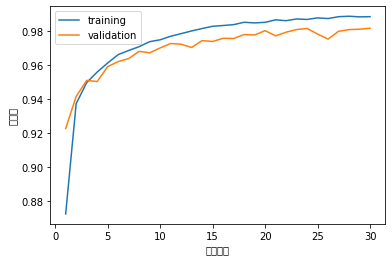

In [30]:
plt.plot(range(1, 30+1),word_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), word_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

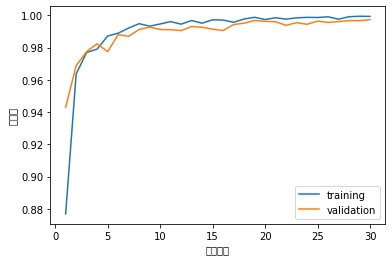

In [31]:
plt.plot(range(1, 30+1),doc_result_all['accuracy'] , label="training")
plt.plot(range(1, 30+1), doc_result_all['val_accuracy'], label="validation")
plt.xlabel('学習回数')
plt.ylabel('正解率')
plt.legend()
plt.show()

In [32]:
max(word_result_all['val_accuracy'])

0.9814852833747864

In [33]:
max(doc_result_all['val_accuracy'])

0.9973305881023407

In [34]:
data_word2, labels_word2= train_data(data_word,labels_word)
result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)

トレーニングデータの1の数    : 5858
トレーニングデータ1の割合    : 50.1 %
テストデータの１の数            : 1445
テストデータの1の割合          : 49.5 %
Epoch 1/30
731/731 [==============================] - 1s 848us/step - loss: 0.3001 - accuracy: 0.8734 - val_loss: 0.2106 - val_accuracy: 0.9179
Epoch 2/30
731/731 [==============================] - 1s 724us/step - loss: 0.1757 - accuracy: 0.9363 - val_loss: 0.1608 - val_accuracy: 0.9449
Epoch 3/30
731/731 [==============================] - 1s 716us/step - loss: 0.1449 - accuracy: 0.9486 - val_loss: 0.1555 - val_accuracy: 0.9418
Epoch 4/30
731/731 [==============================] - 1s 710us/step - loss: 0.1248 - accuracy: 0.9567 - val_loss: 0.1408 - val_accuracy: 0.9524
Epoch 5/30
731/731 [==============================] - 1s 722us/step - loss: 0.1135 - accuracy: 0.9588 - val_loss: 0.1344 - val_accuracy: 0.9521
Epoch 6/30
731/731 [==============================] - 1s 729us/step - loss: 0.1010 - accuracy: 0.9638 - val_loss: 0.1001 - val_accuracy: 0.9665
Epoch 7/30
731/731 [=======

In [35]:
#全データの精度
data_word2,labels_word2 =  np.array(data_word),np.array(labels_word)
#data_word_one_hot = np_utils.to_categorical(data_word2)
prob = model.predict(data_word2, batch_size=len(data_word2))
y_pred = np.argmax(prob, axis=1)
# 精度を検証する。
accuracy = accuracy_score(labels_word2, y_pred)
print('accuracy: {:.2%}'.format(accuracy))

accuracy: 98.46%


In [36]:
data_doc2, labels_doc2= train_data(data_doc,labels_doc)
result, accuracy, model, x_test, y_test = gakusyu(data_doc2, labels_doc2)

トレーニングデータの1の数    : 5825
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1478
テストデータの1の割合          : 50.6 %
Epoch 1/30
731/731 [==============================] - 1s 1ms/step - loss: 0.3127 - accuracy: 0.8643 - val_loss: 0.1413 - val_accuracy: 0.9524
Epoch 2/30
731/731 [==============================] - 1s 1ms/step - loss: 0.1216 - accuracy: 0.9607 - val_loss: 0.0900 - val_accuracy: 0.9771
Epoch 3/30
731/731 [==============================] - 1s 978us/step - loss: 0.0799 - accuracy: 0.9747 - val_loss: 0.0828 - val_accuracy: 0.9812
Epoch 4/30
731/731 [==============================] - 1s 979us/step - loss: 0.0516 - accuracy: 0.9815 - val_loss: 0.0498 - val_accuracy: 0.9795
Epoch 5/30
731/731 [==============================] - 1s 818us/step - loss: 0.0428 - accuracy: 0.9846 - val_loss: 0.0274 - val_accuracy: 0.9897
Epoch 6/30
731/731 [==============================] - 1s 797us/step - loss: 0.0183 - accuracy: 0.9950 - val_loss: 0.0166 - val_accuracy: 0.9962
Epoch 7/30
731/731 [===========

In [37]:
data_doc2,labels_doc2 =  np.array(data_doc),np.array(labels_doc)
#data_word_one_hot = np_utils.to_categorical(data_word2)
prob = model.predict(data_doc2, batch_size=len(data_doc2))
y_pred = np.argmax(prob, axis=1)
# 精度を検証する。
accuracy = accuracy_score(labels_doc2, y_pred)
print('accuracy: {:.2%}'.format(accuracy))

accuracy: 99.79%
